In [1]:
cd ..

/data/2022F/CS330/project


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import model
import utils
import train

## Task Setup
Setup datasets, loss functions, etc.

In [4]:
import transformers
import experiment_lang

device='cuda:1'

bert, tokenizer = experiment_lang.get_model_and_tokenizer('prajjwal1/bert-medium', transformers.AutoModelForSequenceClassification)
stop_tokens = experiment_lang.get_stop_tokens(tokenizer)

def loss_func(logits, labels):
    #print(logits, labels)
    return F.binary_cross_entropy_with_logits(logits, labels[..., None].float())
def get_language_task(name):
    ds_train, ds_val = experiment_lang.get_dataset(name)

    generator_train = experiment_lang.ClassificationDataGenerator(ds_train, tokenizer, device, batchSize=32)
    generator_val = experiment_lang.ClassificationDataGenerator(ds_val, tokenizer, device, batchSize=32)
    return {
        'train_gen': generator_train,
        'val_gen': generator_val,
        'loss': loss_func, #lambda logits, labels: F.binary_cross_entropy_with_logits(logits, labels[..., None]),
        'predict': lambda logits: torch.sigmoid(logits) > 0.5,
        'metric': experiment_lang.get_acc,
    }

tasks = {
    'mrpc': get_language_task('glue/mrpc'),
    'qnli': get_language_task('glue/qnli'),
}
task_keys = list(tasks.keys())


Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

## Compute gradient alignments

In [5]:
modelShared = experiment_lang.TaskAwareBert(bert, list(tasks.keys()), 'shared').to(device)
modelShared = modelShared.train()
print(modelShared.training)

grads = train.get_gradients(
    model=modelShared,
    tasks=tasks, 
    steps=200, 
    lr=3e-4,
    DEVICE=device,
    param_keys=modelShared.backbone_trainables
)

True


Losses: 0.585, 0.734: 100%|██████████| 200/200 [17:00<00:00,  5.10s/it]


In [6]:
def filter_dict(x):
    return {k:v for k,v in x.items() if isinstance(x, int)}
def filter_dict2(x):
    
    return {k:filter_dict(v) for k,v in x.items()
           if len(filter_dict(v)) > 0}
def filter_dict3(x):
    return [filter_dict(g) for g in x if len(filter_dict(g)) > 0]
filter_dict3(grads)

[]

['backbone.bert.encoder.layer.0.attention.self.query.weight', 'backbone.bert.encoder.layer.0.attention.self.query.bias', 'backbone.bert.encoder.layer.0.attention.self.key.weight', 'backbone.bert.encoder.layer.0.attention.self.key.bias', 'backbone.bert.encoder.layer.0.attention.self.value.weight', 'backbone.bert.encoder.layer.0.attention.self.value.bias', 'backbone.bert.encoder.layer.0.attention.output.dense.weight', 'backbone.bert.encoder.layer.0.attention.output.dense.bias', 'backbone.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.bert.encoder.layer.0.intermediate.dense.weight', 'backbone.bert.encoder.layer.0.intermediate.dense.bias', 'backbone.bert.encoder.layer.0.output.dense.weight', 'backbone.bert.encoder.layer.0.output.dense.bias', 'backbone.bert.encoder.layer.0.output.LayerNorm.weight', 'backbone.bert.encoder.layer.0.output.LayerNorm.bias', 'backbone.bert.encoder.layer.1.attention.self.query.wei

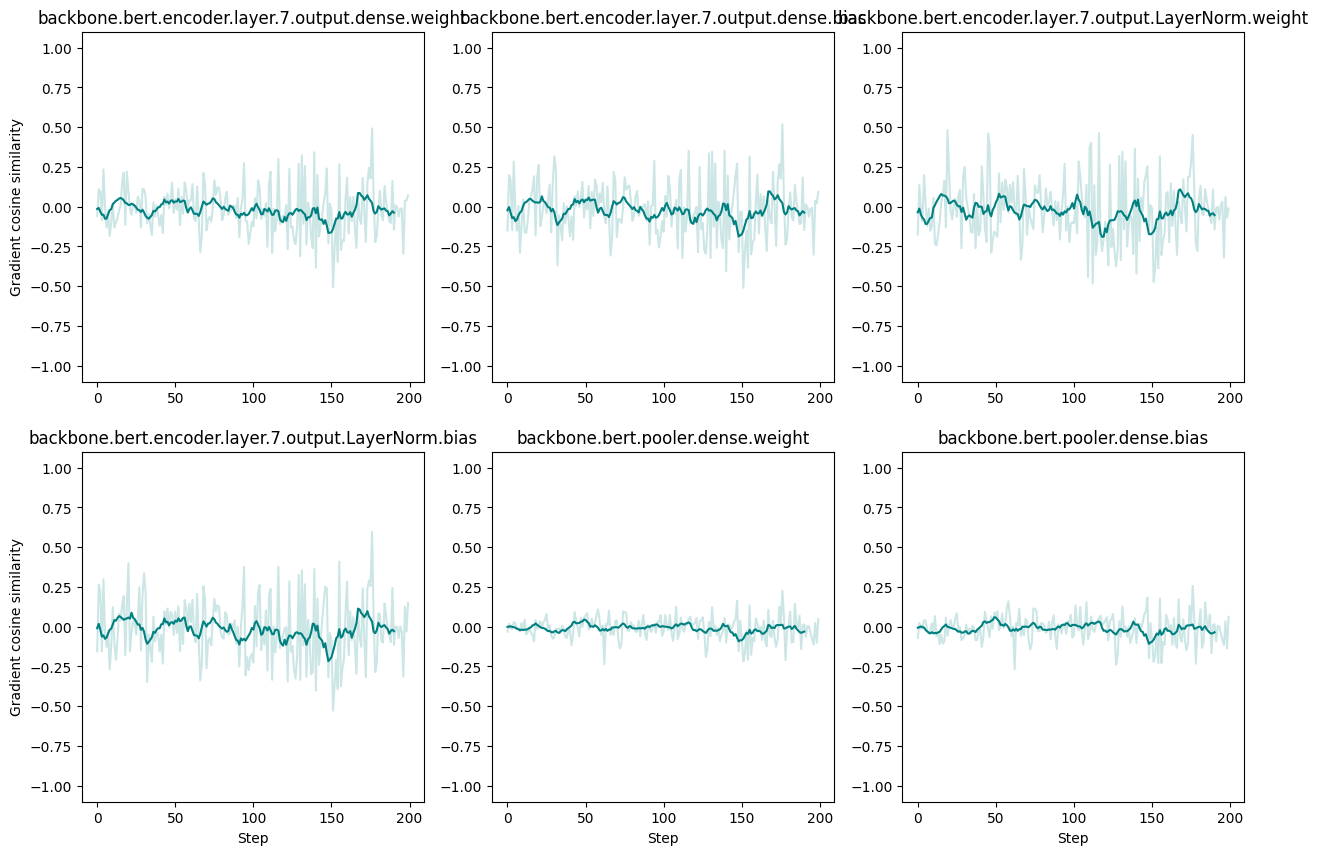

In [7]:
param_keys = modelShared.backbone_trainables
print(param_keys)

heuristic_results = {}

# plots
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

availableKeys = n_rows * n_cols

for i, key in enumerate(param_keys[-availableKeys-2:-2]):
    # get gradients
    g0 = utils.stack_grad(grads, task_keys[0], key)
    g1 = utils.stack_grad(grads, task_keys[1], key)
    
    # heuristics computations
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = utils.low_pass_filter(cosine[None], filter_size=10)[0][0]
    
    avg_smoothed_cos = smooth_cos.mean()
    std_cos = cosine.std()
    
    heuristic_results[key] = {'avg_cos': avg_smoothed_cos, 'std_cos': std_cos}
      
    # plot
    row, col = i // n_cols, i % n_cols
    ax = axes[row][col]    
    ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    ax.set_ylim([-1.1, 1.1])
    ax.plot(cosine, color='teal', alpha=0.2)
    ax.plot(smooth_cos, color='teal')

In [8]:
heuristic_results

{'backbone.bert.encoder.layer.7.output.dense.weight': {'avg_cos': -0.020290384,
  'std_cos': tensor(0.1491)},
 'backbone.bert.encoder.layer.7.output.dense.bias': {'avg_cos': -0.021224905,
  'std_cos': tensor(0.1708)},
 'backbone.bert.encoder.layer.7.output.LayerNorm.weight': {'avg_cos': -0.023578605,
  'std_cos': tensor(0.1939)},
 'backbone.bert.encoder.layer.7.output.LayerNorm.bias': {'avg_cos': -0.019567983,
  'std_cos': tensor(0.1935)},
 'backbone.bert.pooler.dense.weight': {'avg_cos': -0.009672352,
  'std_cos': tensor(0.0715)},
 'backbone.bert.pooler.dense.bias': {'avg_cos': -0.011172522,
  'std_cos': tensor(0.0855)}}

## Experiments

In [9]:
modelShared = experiment_lang.TaskAwareBert(bert, list(tasks.keys()), 'shared').to(device)

fully_shared_exp = train.train_and_evaluate(
    model=modelShared,
    tasks=tasks,
    steps=500,
    lr=1e-4,
    eval_every=50,
    DEVICE=device
)

Losses: 0.637, 0.709; Metrics: 0.344, 0.594: 100%|██████████| 500/500 [50:43<00:00,  6.09s/it]  


In [10]:
modelSeparate = experiment_lang.TaskAwareBert(bert, list(tasks.keys()), 'separate').to(device)
separate_exp = train.train_and_evaluate(
    model=modelSeparate,
    tasks=tasks,
    steps=500,
    lr=1e-4,
    eval_every=50,
    DEVICE=device,
)

Losses: 0.660, 0.683; Metrics: 0.344, 0.469: 100%|██████████| 500/500 [51:33<00:00,  6.19s/it]  


In [11]:
modelSurgical = experiment_lang.TaskAwareBert(bert, list(tasks.keys()), 'surgical').to(device)
surgical_exp = train.train_and_evaluate(
    model=modelSurgical,
    tasks=tasks,
    steps=500,
    lr=1e-4,
    eval_every=50,
    DEVICE=device,
)

Losses: 0.603, 0.703; Metrics: 0.250, 0.469: 100%|██████████| 500/500 [52:33<00:00,  6.31s/it]  


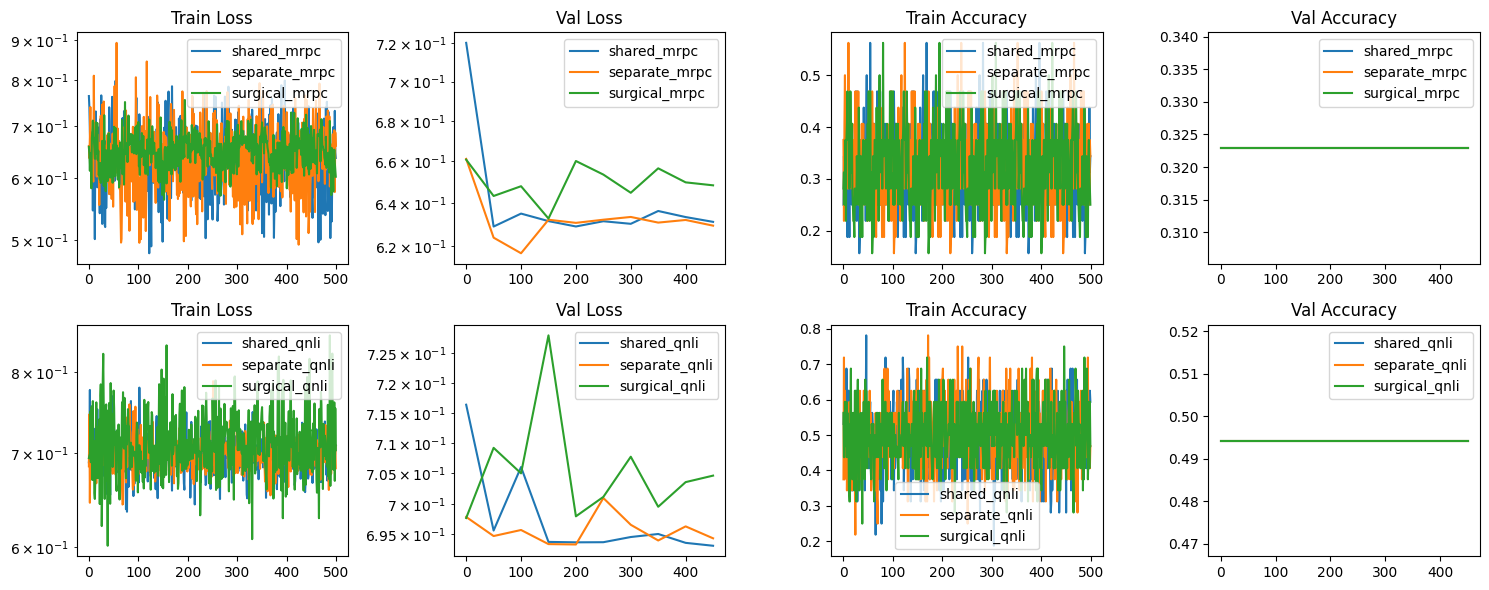

In [23]:

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for iTask, task_name in enumerate(tasks):

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [(s, l[task_name]) for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, float(m[task_name])) for s, m in metrics]
        em = [(s, float(m[task_name])) for s, m in eval_metrics]
    
        # plot
        ax = axes[iTask][0]
        tl_x, tl_y = zip(*tl)
        ax.plot(tl_x, tl_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Loss')
        ax.set_yscale('log')
        ax.legend()

        ax = axes[iTask][1]
        el_x, el_y = zip(*el)
        ax.plot(el_x, el_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Loss')
        ax.set_yscale('log')
        ax.legend()

        ax = axes[iTask][2]
        tm_x, tm_y = zip(*tm)
        ax.plot(tm_x, tm_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Accuracy')
        #ax.set_ylim([0.95, 0.999])
        ax.legend()

        ax = axes[iTask][3]
        em_x, em_y = zip(*em)
        ax.plot(em_x, em_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Accuracy')
        #ax.set_ylim([0.95, 0.999])
        ax.legend()
fig.tight_layout()

In [25]:
import pickle
from pathlib import Path

pathCache = Path('cache/experiment-lang')
pathCache.mkdir(exist_ok=True, parents=True)
with open(pathCache / "shared.pickle", "wb") as f:
    pickle.dump(fully_shared_exp, f)
with open(pathCache / "separate.pickle", "wb") as f:
    pickle.dump(separate_exp, f)
with open(pathCache / "surgical.pickle", "wb") as f:
    pickle.dump(surgical_exp, f)

In [19]:
em = [(s, float(m['qnli'])) for s, m in eval_metrics]

In [22]:
modelSurgical.training

True